In [1]:
# can plot 2d histograms of arbitrary variables stored in the tree

In [2]:
import sys
sys.path.insert(0, '/home/llr/cms/wind/cmssw/CMSSW_9_4_2/src/ZZAnalysis/AnalysisStep/test/Python/')

In [3]:
from trainlib.FileCollection import FileCollection
import trainlib.cuts as cuts
from trainlib.utils import read_data
from trainlib.config import Config
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import re
import pandas as pd
import numpy as np

Welcome to JupyROOT 6.10/09


In [4]:
def extract_column(df, colstring):
    if '[' in colstring and ']' in colstring:
        col, sorted_col_order, _ = re.split('[\[\]]', colstring)
        sorted_col, order = re.split('\|', sorted_col_order)
        cf = extract_order_filtered(df, sorted_col, [col], int(order))
    else:
        cf = df[[colstring]]
    return cf

In [5]:
def extract_order_filtered(df, sorted_column, columns, order):
    extracted_raw = extract_order(df, sorted_column, columns, order)

    if any("Jet" in col for col in extracted_raw.columns):
        # apply the jet-pt cut
        mask_column = extract_order(df, "JetPt", ["JetPt"], order)
        mask = mask_column < 30.0
        extracted_raw[mask.as_matrix()] = 0.0

    return extracted_raw

In [6]:
def extract_order(df, sorted_column, columns, order):
    def get_index(row, order, sorted_column):
        sorted_column = row[sorted_column]
        if order >= len(sorted_column):
            return -1
        else:
            return np.flipud(np.argsort(sorted_column))[order]

    index_column = pd.DataFrame(df.transform(lambda row: get_index(row, order, sorted_column), axis = 1, raw = True))
    index_column.columns = ["index"]
    df_temp = pd.concat([index_column, df], axis = 1)

    def get_element(row, column_name):
        if row["index"] == -1:
            return 0
        else:
            return row[column_name][row["index"]]

    extracted_cols = pd.DataFrame()
    for column in columns:
        extracted_col = pd.DataFrame(df_temp.transform(lambda row: get_element(row, column), axis = 1, raw = True))
        extracted_col.columns = [column + "_" + str(order)]
        extracted_cols = pd.concat([extracted_cols, extracted_col], axis = 1)

    return extracted_cols

In [7]:
def plot_2d_histogram(df, x_var, y_var, x_range, y_range, x_label, y_label, log_scale = True):
    x_data = extract_column(df, x_var).as_matrix().flatten()
    y_data = extract_column(df, y_var).as_matrix().flatten()
    
    print str(np.corrcoef(x_data, y_data))
    
    x_edges = np.linspace(x_range[0], x_range[1], x_range[2])
    y_edges = np.linspace(y_range[0], y_range[1], y_range[2])
    
    weights = np.full(len(x_data), 1.0 / len(x_data))
    
    H, x_edges, y_edges = np.histogram2d(x_data, y_data, bins = (x_edges, y_edges), weights = weights)
    
    return plot_2d_raw(H.transpose(), x_edges, y_edges, x_label, y_label, log_scale = log_scale), H

In [8]:
def plot_2d_histogram_relative(df, x_var, y_var, x_range, y_range, x_label, y_label, log_scale = True):
    x_data = extract_column(df, x_var).as_matrix().flatten()
    y_data = extract_column(df, y_var).as_matrix().flatten()
    
    y_data = y_data / x_data
    
    x_edges = np.linspace(x_range[0], x_range[1], x_range[2])
    y_edges = np.linspace(y_range[0], y_range[1], y_range[2])
    
    weights = np.full(len(x_data), 1.0 / len(x_data))
    
    H, x_edges, y_edges = np.histogram2d(x_data, y_data, bins = (x_edges, y_edges), weights = weights)
    
    return plot_2d_raw(H.transpose(), x_edges, y_edges, x_label, y_label, log_scale = log_scale), H

In [9]:
def plot_1d_histogram(dfs, x_vars, data_labels, x_range, x_label, y_label = "", log_scale = True):
    
    fig = plt.figure(figsize = (8,5))
    ax = fig.add_subplot(111)
    
    for df, x_var, data_label in zip(dfs, x_vars, data_labels):
        x_data = extract_column(df, x_var).as_matrix().flatten()

        x_edges = np.linspace(x_range[0], x_range[1], x_range[2])
        bin_width = (x_range[1] - x_range[0]) / x_range[2]
        weights = np.full(len(x_data), 1.0 / (bin_width * len(x_data)))
        H, x_edges = np.histogram(x_data, bins = x_edges, weights = weights)

        cax = ax.hist(x_data, bins = x_edges, log = log_scale, weights = weights, histtype = 'step', label = data_label)
        ax.set_xlabel(x_label, fontsize = 15)
        ax.set_ylabel(y_label, fontsize = 12)
        ax.set_xlim([x_range[0], x_range[1] - 0.01])
        
    ax.legend(loc = 'lower left')
        
    return fig, H

In [10]:
def plot_2d_raw(H, x_edges, y_edges, x_label, y_label, log_scale = True):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
        
    if log_scale:
        cax = ax.imshow(H, interpolation = "nearest", cmap = "hot", origin = "low", aspect = 'auto',
                        extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                       norm = LogNorm(vmin = 0.0001, vmax = 1))
    else:
        cax = ax.imshow(H, interpolation = "nearest", cmap = "hot", origin = "low", aspect = 'auto',
                extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
    
    ax.set_xlabel(x_label, fontsize = 15)
    ax.set_ylabel(y_label, fontsize = 15)
        
    return fig

In [11]:
j2cut = lambda row: row["nCleanedJetsPt30"] >= 2

In [12]:
j0cut = lambda row: row["nCleanedJetsPt30"] == 0

In [13]:
j1cut = lambda row: row["nCleanedJetsPt30"] == 1

In [14]:
whhadr_2jcut = lambda row: cuts.WHhadr_cut(row) and j2cut(row)

In [15]:
zhhadr_2jcut = lambda row: cuts.ZHhadr_cut(row) and j2cut(row)

In [16]:
zhlept_2jcut = lambda row: cuts.ZHlept_cut(row) and j2cut(row)

In [17]:
zhlept_mass_cut = lambda row: cuts.ZHlept_cut(row) and cuts.mZZ_cut(row)
whlept_mass_cut = lambda row: cuts.WHlept_cut(row) and cuts.mZZ_cut(row)

In [18]:
local_mass_cut = lambda row: row["ZZMass"] < 140 and row["ZZMass"] > 105

In [19]:
input_stream_VBF_0j = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/VBFH125/ZZ4lAnalysis.root" : j0cut}
input_stream_ggH_0j = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/ggH125/ZZ4lAnalysis.root" : j0cut}
input_stream_VBF_1j = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/VBFH125/ZZ4lAnalysis.root" : j1cut}
input_stream_ggH_1j = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/ggH125/ZZ4lAnalysis.root" : j1cut}
input_stream_VBF_2j = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/VBFH125/ZZ4lAnalysis.root" : j2cut}
input_stream_ggH_2j = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/ggH125/ZZ4lAnalysis.root" : j2cut}

input_stream_VBF = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/VBFH125/ZZ4lAnalysis.root" : cuts.no_cut}

input_stream_ggH = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/ggH125/ZZ4lAnalysis.root" : cuts.no_cut}
input_stream_ggH_allmasses = {
    "/data_CMS/cms/wind/CJLST_NTuples_prepared/ggH120/ZZ4lAnalysis.root" : cuts.no_cut,
    "/data_CMS/cms/wind/CJLST_NTuples_prepared/ggH125/ZZ4lAnalysis.root" : cuts.no_cut,
    "/data_CMS/cms/wind/CJLST_NTuples_prepared/ggH130/ZZ4lAnalysis.root" : cuts.no_cut}
input_stream_WHh = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/WminusH125/ZZ4lAnalysis.root" : whhadr_2jcut,
                    "/data_CMS/cms/wind/CJLST_NTuples_prepared/WplusH125/ZZ4lAnalysis.root" : whhadr_2jcut}
input_stream_WHl = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/WminusH125/ZZ4lAnalysis.root" : cuts.WHlept_cut,
                    "/data_CMS/cms/wind/CJLST_NTuples_prepared/WplusH125/ZZ4lAnalysis.root" : cuts.WHlept_cut}
input_stream_ZHl = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/ZH125/ZZ4lAnalysis.root" : zhlept_2jcut}
input_stream_ZHh = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/ZH125/ZZ4lAnalysis.root" : cuts.ZHhadr_cut}
input_stream_ZX = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/AllData/ZZ4lAnalysis.root": j2cut}
input_stream_ZHh_2j = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/ZH125/ZZ4lAnalysis.root" : zhhadr_2jcut}

input_stream_ZHl_inclusive = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/ZH125/ZZ4lAnalysis.root" : cuts.ZHlept_cut}
input_stream_ZX_inclusive = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/AllData/ZZ4lAnalysis.root": cuts.no_cut}

input_stream_ttHl = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/ttH125/ZZ4lAnalysis.root": cuts.ttHlept_cut}

input_stream_ZHl_augmented = {"/data_CMS/cms/wind/180515_ZX_qq_packaged/CJLST_NTuples/ZH125/ZZ4lAnalysis.root": cuts.ZHlept_cut}
input_stream_ZX_augmented = {"/data_CMS/cms/wind/180515_ZX_qq_packaged/CJLST_NTuples/AllData/ZZ4lAnalysis.root": cuts.no_cut}

input_stream_gg4e = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/ggTo4e_Contin_MCFM701/ZZ4lAnalysis.root": cuts.no_cut}

input_stream_zhlept_mass_cut = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/ZH125/ZZ4lAnalysis.root" : zhlept_mass_cut}
input_stream_whlept_mass_cut = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/WminusH125/ZZ4lAnalysis.root" : whlept_mass_cut,
                    "/data_CMS/cms/wind/CJLST_NTuples_prepared/WplusH125/ZZ4lAnalysis.root" : whlept_mass_cut}

In [20]:
input_stream_qq = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/ZZTo4l/ZZ4lAnalysis.root": cuts.no_cut}
input_stream_qq_masscut = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/ZZTo4l/ZZ4lAnalysis.root": local_mass_cut}

In [24]:
fcoll = FileCollection(input_stream_ttHl, 0.0, 1.0)
plot_data_ttHl = read_data(fcoll, 0, 39000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ttH125/ZZ4lAnalysis.root
collection set up: 1 files, 39490 entries in total, 39490 of which will be used


In [184]:
fcoll = FileCollection(input_stream_zhlept_mass_cut, 0.0, 1.0)
plot_data_zhlept_mass_cut = read_data(fcoll, 0, 61000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ZH125/ZZ4lAnalysis.root
collection set up: 1 files, 61210 entries in total, 61210 of which will be used


In [185]:
fcoll = FileCollection(input_stream_whlept_mass_cut, 0.0, 1.0)
plot_data_whlept_mass_cut = read_data(fcoll, 0, 56000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/WminusH125/ZZ4lAnalysis.root
skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/WplusH125/ZZ4lAnalysis.root
collection set up: 2 files, 56636 entries in total, 56636 of which will be used


In [205]:
fcoll = FileCollection(input_stream_qq, 0.0, 1.0)
plot_data_qq = read_data(fcoll, 0, 155000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ZZTo4l/ZZ4lAnalysis.root
collection set up: 1 files, 155112 entries in total, 155112 of which will be used


In [21]:
fcoll = FileCollection(input_stream_qq_masscut, 0.0, 1.0)
plot_data_qq_masscut = read_data(fcoll, 0, 155000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ZZTo4l/ZZ4lAnalysis.root
collection set up: 1 files, 155112 entries in total, 155112 of which will be used


In [194]:
fcoll = FileCollection(input_stream_VBF_0j, 0.0, 1.0)
plot_data_VBF_0j = read_data(fcoll, 0, 15000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/VBFH125/ZZ4lAnalysis.root
collection set up: 1 files, 62320 entries in total, 62320 of which will be used


In [195]:
fcoll = FileCollection(input_stream_ggH_0j, 0.0, 1.0)
plot_data_ggH_0j = read_data(fcoll, 0, 15000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ggH125/ZZ4lAnalysis.root
collection set up: 1 files, 110483 entries in total, 110483 of which will be used


In [96]:
fcoll = FileCollection(input_stream_VBF_1j, 0.0, 1.0)
plot_data_VBF_1j = read_data(fcoll, 0, 62000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/VBFH125/ZZ4lAnalysis.root
collection set up: 1 files, 62320 entries in total, 62320 of which will be used


In [97]:
fcoll = FileCollection(input_stream_ggH_1j, 0.0, 1.0)
plot_data_ggH_1j = read_data(fcoll, 0, 110000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ggH125/ZZ4lAnalysis.root
collection set up: 1 files, 110483 entries in total, 110483 of which will be used


In [61]:
fcoll = FileCollection(input_stream_VBF_2j, 0.0, 1.0)
plot_data_VBF_2j = read_data(fcoll, 0, 62000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/VBFH125/ZZ4lAnalysis.root
collection set up: 1 files, 62320 entries in total, 62320 of which will be used


In [62]:
fcoll = FileCollection(input_stream_ggH_2j, 0.0, 1.0)
plot_data_ggH_2j = read_data(fcoll, 0, 110000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ggH125/ZZ4lAnalysis.root
collection set up: 1 files, 110483 entries in total, 110483 of which will be used


In [15]:
fcoll = FileCollection(input_stream_ZHl_augmented, 0.0, 1.0)
plot_data_ZHl_augmented = read_data(fcoll, 0, 15000, branches = Config.branches + ["D_ZHl_ggH_ML", "D_ZHl_bkg_ML"])

skimming /data_CMS/cms/wind/180515_ZX_qq_packaged/CJLST_NTuples/ZH125/ZZ4lAnalysis.root
collection set up: 1 files, 15303 entries in total, 15303 of which will be used


In [16]:
fcoll = FileCollection(input_stream_ZX_augmented, 0.0, 1.0)
plot_data_ZX_augmented = read_data(fcoll, 0, 50000, branches = Config.branches + ["D_ZHl_ggH_ML", "D_ZHl_bkg_ML"])

skimming /data_CMS/cms/wind/180515_ZX_qq_packaged/CJLST_NTuples/AllData/ZZ4lAnalysis.root
collection set up: 1 files, 50680 entries in total, 50680 of which will be used


In [17]:
fcoll = FileCollection(input_stream_gg4e, 0.0, 1.0)
plot_data_gg4e = read_data(fcoll, 0, 220000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ggTo4e_Contin_MCFM701/ZZ4lAnalysis.root
collection set up: 1 files, 225637 entries in total, 225637 of which will be used


In [20]:
fcoll = FileCollection(input_stream_ZHl_inclusive, 0.0, 1.0)
plot_data_ZHl_inclusive = read_data(fcoll, 0, 61000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ZH125/ZZ4lAnalysis.root
collection set up: 1 files, 61210 entries in total, 61210 of which will be used


In [117]:
fcoll = FileCollection(input_stream_ZHh, 0.0, 1.0)
plot_data_ZHh = read_data(fcoll, 0, 61000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ZH125/ZZ4lAnalysis.root
collection set up: 1 files, 61210 entries in total, 61210 of which will be used


In [148]:
fcoll = FileCollection(input_stream_ZHh_2j, 0.0, 1.0)
plot_data_ZHh_2j = read_data(fcoll, 0, 61000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ZH125/ZZ4lAnalysis.root
collection set up: 1 files, 61210 entries in total, 61210 of which will be used


In [20]:
fcoll = FileCollection(input_stream_ZX_inclusive, 0.0, 1.0)
plot_data_ZX_inclusive = read_data(fcoll, 0, 61000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/AllData/ZZ4lAnalysis.root
collection set up: 1 files, 63349 entries in total, 63349 of which will be used


In [21]:
fcoll = FileCollection(input_stream_ZHl, 0.0, 1.0)
plot_data_ZHl = read_data(fcoll, 0, 61000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ZH125/ZZ4lAnalysis.root
collection set up: 1 files, 61210 entries in total, 61210 of which will be used


In [35]:
fcoll = FileCollection(input_stream_WHl, 0.0, 1.0)
plot_data_WHl = read_data(fcoll, 0, 56000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/WminusH125/ZZ4lAnalysis.root
skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/WplusH125/ZZ4lAnalysis.root
collection set up: 2 files, 56636 entries in total, 56636 of which will be used


In [23]:
fcoll = FileCollection(input_stream_ZX, 0.0, 1.0)
plot_data_ZX = read_data(fcoll, 0, 61000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/AllData/ZZ4lAnalysis.root
collection set up: 1 files, 63349 entries in total, 63349 of which will be used


In [21]:
fcoll = FileCollection(input_stream_VBF, 0.0, 1.0)
plot_data_VBF = read_data(fcoll, 0, 62000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/VBFH125/ZZ4lAnalysis.root
collection set up: 1 files, 62320 entries in total, 62320 of which will be used


In [22]:
fcoll = FileCollection(input_stream_ggH, 0.0, 1.0)
plot_data_ggH = read_data(fcoll, 0, 110000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ggH125/ZZ4lAnalysis.root
collection set up: 1 files, 110483 entries in total, 110483 of which will be used


In [25]:
fcoll = FileCollection(input_stream_ggH, 0.0, 1.0)
plot_data_ggH_allmasses = read_data(fcoll, 0, 221000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ggH125/ZZ4lAnalysis.root
collection set up: 1 files, 110483 entries in total, 110483 of which will be used


IndexError: global index out of range: requested entries 0 through 221000, but max. index is 110482

In [26]:
fcoll = FileCollection(input_stream_WHh, 0.0, 1.0)
plot_data_WHh = read_data(fcoll, 0, 56000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/WminusH125/ZZ4lAnalysis.root
skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/WplusH125/ZZ4lAnalysis.root
collection set up: 2 files, 56636 entries in total, 56636 of which will be used


/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


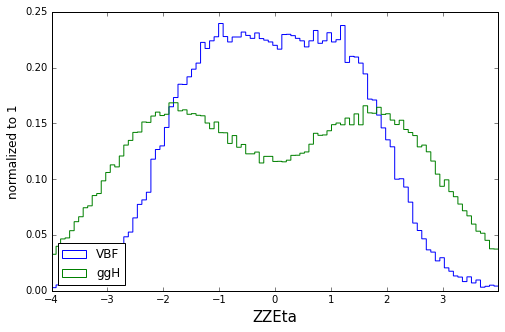

In [24]:
fig, H_ZX = plot_1d_histogram([plot_data_VBF, plot_data_ggH], 
                              ["ZZEta", "ZZEta"], 
                              ["VBF", "ggH"], (-4, 4, 100.), 'ZZEta', "normalized to 1", log_scale = False)
#plt.savefig("ZX_ZHl_Zhl_ggH.pdf")
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


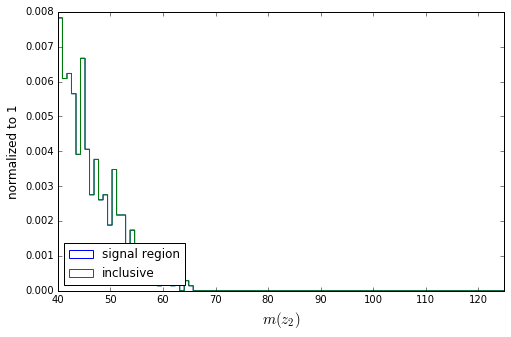

In [22]:
fig, H_ZX = plot_1d_histogram([plot_data_qq_masscut, plot_data_qq_masscut], 
                              ["Z2Mass", "Z2Mass"], 
                              ["signal region", "inclusive"], (40., 125, 100.), r'$m(z_2)$', "normalized to 1", log_scale = False)
#plt.savefig("ZX_ZHl_Zhl_ggH.pdf")
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


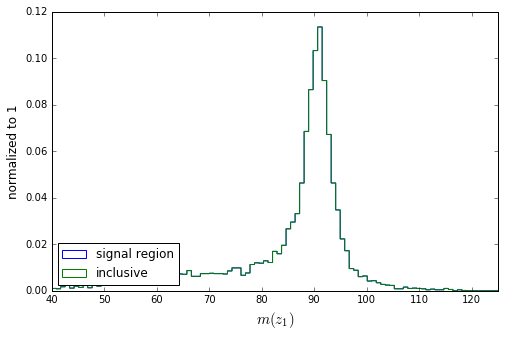

In [23]:
fig, H_ZX = plot_1d_histogram([plot_data_qq_masscut, plot_data_qq_masscut], 
                              ["Z1Mass", "Z1Mass"],
                              ["signal region", "inclusive"], (40., 125, 100.), r'$m(z_1)$', "normalized to 1", log_scale = False)
#plt.savefig("ZX_ZHl_Zhl_ggH.pdf")
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


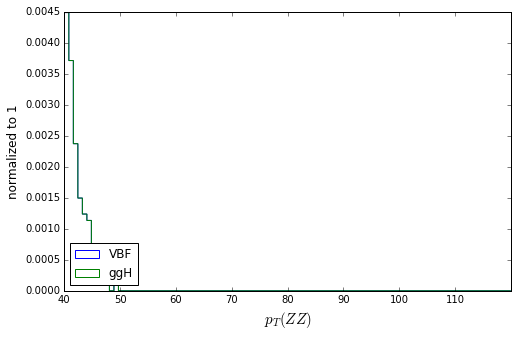

In [20]:
fig, H_ZX = plot_1d_histogram([plot_data_qq_masscut, plot_data_qq_masscut],
                              ["Z2Mass", "Z2Mass"], 
                              ["VBF", "ggH"], (40., 120, 100.), r'$p_T(ZZ)$', "normalized to 1", log_scale = False)
#plt.savefig("ZX_ZHl_Zhl_ggH.pdf")
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


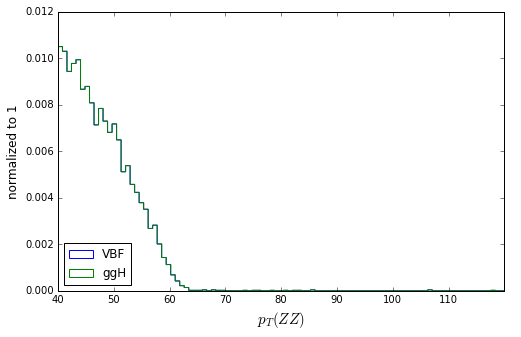

In [235]:
fig, H_ZX = plot_1d_histogram([plot_data_VBF, plot_data_VBF],
                              ["Z2Mass", "Z2Mass"], 
                              ["VBF", "ggH"], (40., 120, 100.), r'$p_T(ZZ)$', "normalized to 1", log_scale = False)
#plt.savefig("ZX_ZHl_Zhl_ggH.pdf")
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


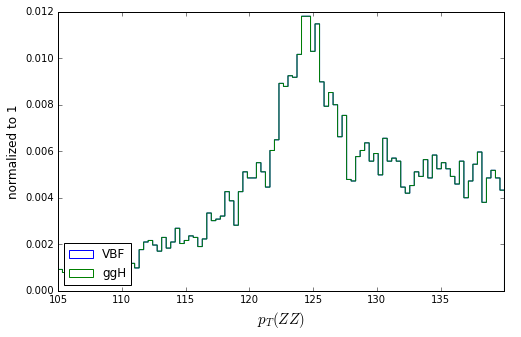

In [25]:
fig, H_ZX = plot_1d_histogram([plot_data_ZHl_inclusive, plot_data_ZHl_inclusive],
                              ["ZZMass", "ZZMass"], 
                              ["VBF", "ggH"], (105., 140, 100.), r'$p_T(ZZ)$', "normalized to 1", log_scale = False)
#plt.savefig("ZX_ZHl_Zhl_ggH.pdf")
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


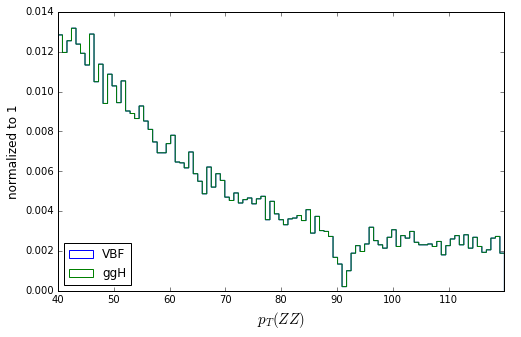

In [28]:
fig, H_ZX = plot_1d_histogram([plot_data_ttHl, plot_data_ttHl],
                              ["Z2Mass", "Z2Mass"], 
                              ["VBF", "ggH"], (40., 120, 100.), r'$p_T(ZZ)$', "normalized to 1", log_scale = False)
#plt.savefig("ZX_ZHl_Zhl_ggH.pdf")
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


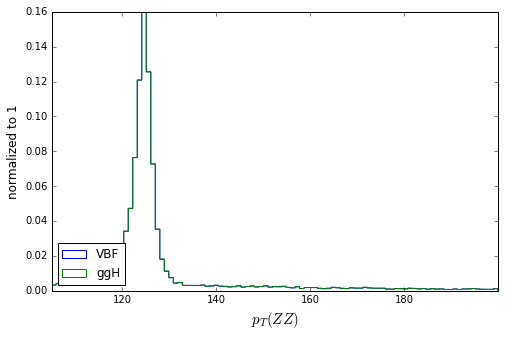

In [36]:
fig, H_ZX = plot_1d_histogram([plot_data_WHl, plot_data_WHl],
                              ["ZZMass", "ZZMass"], 
                              ["VBF", "ggH"], (105., 200, 100.), r'$p_T(ZZ)$', "normalized to 1", log_scale = False)
#plt.savefig("ZX_ZHl_Zhl_ggH.pdf")
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


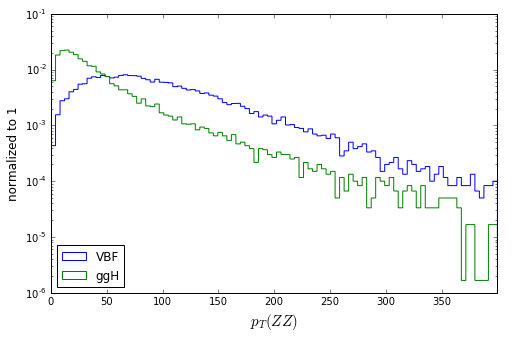

In [32]:
fig, H_ZX = plot_1d_histogram([plot_data_VBF_0j, plot_data_ggH_0j], 
                              ["ZZPt", "ZZPt"], 
                              ["VBF", "ggH"], (0., 400, 100.), r'$p_T(ZZ)$', "normalized to 1", log_scale = True)
#plt.savefig("ZX_ZHl_Zhl_ggH.pdf")
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


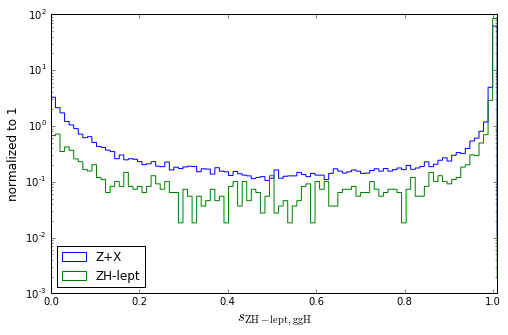

In [100]:
fig, H_ZX = plot_1d_histogram([plot_data_ZX_augmented, plot_data_ZHl_augmented], 
                              ["D_ZHl_ggH_ML", "D_ZHl_ggH_ML"], 
                              ["Z+X", "ZH-lept"], (0., 1.02, 100.), r'$s_{\mathrm{ZH-lept, ggH}}$', "normalized to 1", log_scale = True)
#plt.savefig("ZX_ZHl_Zhl_ggH.pdf")
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


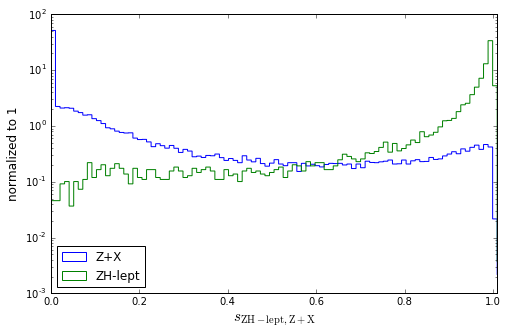

In [108]:
fig, H_ZX = plot_1d_histogram([plot_data_ZX_augmented, plot_data_ZHl_augmented], 
                              ["D_ZHl_bkg_ML", "D_ZHl_bkg_ML"], 
                              ["Z+X", "ZH-lept"], (0., 1.02, 100.), r'$s_{\mathrm{ZH-lept, Z+X}}$', "normalized to 1", log_scale = True)
#plt.savefig("ZX_ZHl_Zhl_ZX.pdf")
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


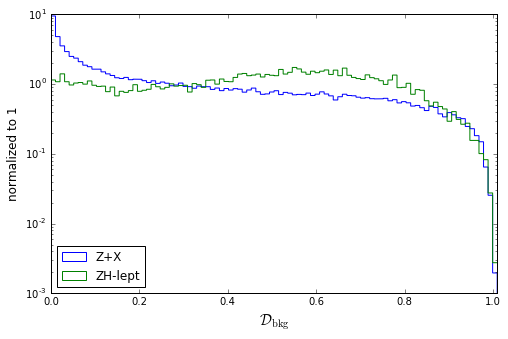

In [29]:
fig, H_ZX = plot_1d_histogram([plot_data_ZX_augmented, plot_data_ZHl_augmented], 
                              ["D_bkg_ME", "D_bkg_ME"], 
                              ["Z+X", "ZH-lept"], (0., 1.02, 100.), r'$\mathcal{D}_{\mathrm{bkg}}$', "normalized to 1", log_scale = True)
#plt.savefig("ZX_ZHl_Zhl_ZX.pdf")
plt.show()

In [52]:
fig, H_ZHl = plot_2d_histogram(plot_data_ZHl, "JetEta[JetPt|0]", "JetEta[JetPt|1]", (-4, 4, 15), (-4, 4, 15), 
                               r'$\eta_{\,\,0}$', r'$\eta_{\,\,1}$', log_scale = False)
plt.savefig("ZHl_JetEta.pdf")
#plt.show()

In [53]:
fig, H_ZX = plot_2d_histogram(plot_data_ZX, "JetEta[JetPt|0]", "JetEta[JetPt|1]", (-4, 4, 15), (-4, 4, 15), 
                              r'$\eta_{\,\,0}$', r'$\eta_{\,\,1}$', log_scale = False)
plt.savefig("ZX_JetEta.pdf")
#plt.show()

In [40]:
fig, H_ZX = plot_1d_histogram([plot_data_ZX_inclusive, plot_data_ZHl_inclusive], 
                              ["nCleanedJetsPt30", "nCleanedJetsPt30"], 
                              ["Z+X", "ZH-lept"], (-0.5, 4.5, 6), r'$n_{\mathrm{Jets}}$', "normalized to 1", log_scale = True)
plt.savefig("ZX_ZHl_nCleanedJetsPt30.pdf")
#plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


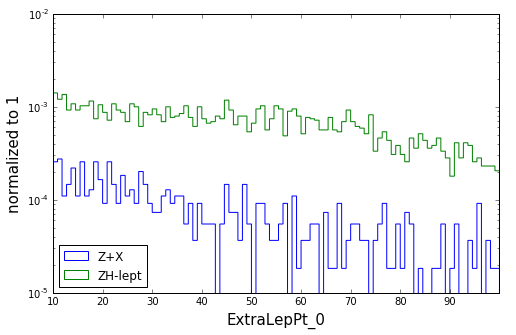

In [38]:
fig, H_ZX = plot_1d_histogram([plot_data_ZX_inclusive, plot_data_ZHl_inclusive], 
                              ["ExtraLepPt[ExtraLepPt|0]", "ExtraLepPt[ExtraLepPt|0]"], 
                              ["Z+X", "ZH-lept"], (10, 100., 100.), "ExtraLepPt_0", "normalized to 1", log_scale = True)
plt.show()

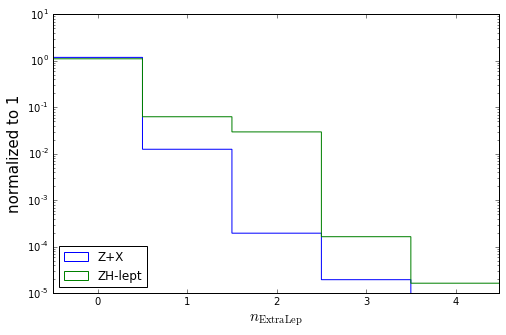

In [26]:
fig, H_ZX = plot_1d_histogram([plot_data_ZX_inclusive, plot_data_ZHl_inclusive], 
                              ["nExtraLep", "nExtraLep"], 
                              ["Z+X", "ZH-lept"], (-0.5, 4.5, 6), r'$n_{\mathrm{ExtraLep}}$', "normalized to 1", log_scale = True)
plt.show()

In [41]:
fig, H_ZX = plot_1d_histogram([plot_data_ZX_inclusive, plot_data_ZHl_inclusive], 
                              ["PFMET", "PFMET"], 
                              ["Z+X", "ZH-lept"], (0, 300, 100), "PFMET", "normalized to 1", log_scale = True)
plt.savefig("ZX_ZHl_PFMET.pdf")
#plt.show()

In [42]:
fig, H_ZX = plot_1d_histogram([plot_data_ZX_inclusive, plot_data_ZHl_inclusive], 
                              ["ZZPt", "ZZPt"], 
                              ["Z+X", "ZH-lept"], (0, 300, 100), "ZZPt", "normalized to 1", log_scale = True)
plt.savefig("ZX_ZHl_ZZPt.pdf")
#plt.show()

In [43]:
fig, H_ZX = plot_1d_histogram([plot_data_ZX_inclusive, plot_data_ZHl_inclusive], 
                              ["Z2Pt", "Z2Pt"], 
                              ["Z+X", "ZH-lept"], (0, 300, 100), "Z2Pt", "normalized to 1", log_scale = True)
plt.savefig("ZX_ZHl_Z2Pt.pdf")
#plt.show()

In [44]:
fig, H_ZX = plot_1d_histogram([plot_data_ZX_inclusive, plot_data_ZHl_inclusive], 
                              ["Z1Pt", "Z1Pt"], 
                              ["Z+X", "ZH-lept"], (0, 300, 100), "Z1Pt", "normalized to 1", log_scale = True)
plt.savefig("ZX_ZHl_Z1Pt.pdf")
#plt.show()

In [109]:
fig, H_ZX = plot_1d_histogram([plot_data_ZX_inclusive, plot_data_ZHl_inclusive], 
                              ["ZZEta", "ZZEta"], 
                              ["Z+X", "ZH-lept"], (-4., 4., 100), "ZZEta", "normalized to 1", log_scale = True)
plt.savefig("ZX_ZHl_ZZEta.pdf")
#plt.show()

In [45]:
fig, H_ZX = plot_1d_histogram([plot_data_ZX_inclusive, plot_data_ZHl_inclusive], 
                              ["ZZMass_masked", "ZZMass_masked"], 
                              ["Z+X", "ZH-lept"], (150, 300, 100), "ZZMass", "normalized to 1", log_scale = True)
plt.savefig("ZX_ZHl_ZZMass.pdf")
#plt.show()

In [46]:
fig, H_ZX = plot_1d_histogram([plot_data_ZX_inclusive, plot_data_ZHl_inclusive], 
                              ["Z1Mass", "Z1Mass"], 
                              ["Z+X", "ZH-lept"], (40., 120, 100), "Z1Mass", "normalized to 1", log_scale = True)
plt.savefig("ZX_ZHl_Z1Mass.pdf")
#plt.show()

In [47]:
fig, H_ZX = plot_1d_histogram([plot_data_ZX_inclusive, plot_data_ZHl_inclusive], 
                              ["Z2Mass", "Z2Mass"], 
                              ["Z+X", "ZH-lept"], (15., 120, 100), "Z2Mass", "normalized to 1", log_scale = True)
plt.savefig("ZX_ZHl_Z2Mass.pdf")
#plt.show()

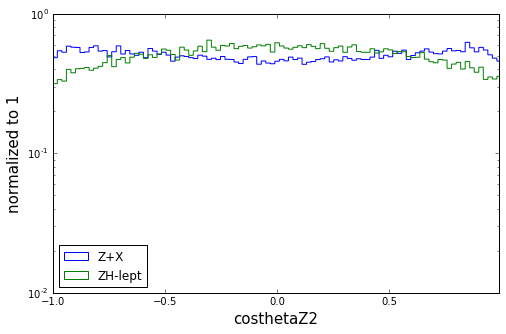

In [34]:
fig, H_ZX = plot_1d_histogram([plot_data_ZX_inclusive, plot_data_ZHl_inclusive], 
                              ["helcosthetaZ2", "helcosthetaZ2"], 
                              ["Z+X", "ZH-lept"], (-1., 1., 100), "costhetaZ2", "normalized to 1", log_scale = True)
plt.show()

In [27]:
fig, H_VBF = plot_2d_histogram(plot_data_VBF, "JetPt[JetPt|0]", "JetPt[JetPt|1]", (30, 500, 10), (30, 500, 10), "Pt_0", "Pt_1")

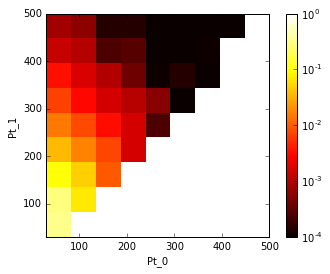

In [28]:
plt.show()

In [24]:
fig, _ = plot_2d_histogram(plot_data_VBF, "JetEta[JetPt|0]", "JetEta[JetPt|1]", (-2,2,20), (-2,2,20), r'$\eta_{0}$', r'$\eta_{1}$', False)

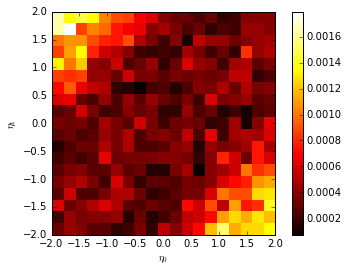

In [25]:
plt.show()

In [227]:
fig, H_ggH = plot_2d_histogram(plot_data_ggH, "JetPt[JetPt|0]", "JetPt[JetPt|1]", (30, 500, 10), (30, 500, 10))

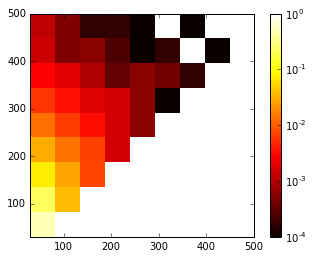

In [228]:
plt.show()

In [229]:
fig, _ = plot_2d_histogram(plot_data_ggH, "JetEta[JetPt|0]", "JetEta[JetPt|1]", (-2,2,10), (-2,2,10))

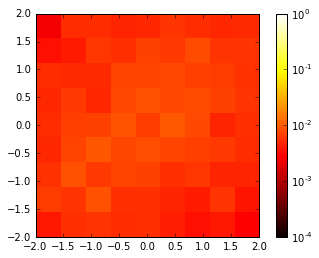

In [230]:
plt.show()

In [165]:
fig, _ = plot_2d_histogram(plot_data_VBF_2j, "JetEta[JetPt|0]", "JetEta[JetPt|1]", (-3,3,20), (-3,3,20), r'$\eta_{0}$', r'$\eta_{1}$', False)

[[ 1.         -0.58539255]
 [-0.58539255  1.        ]]


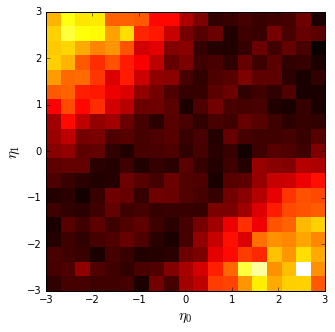

In [166]:
plt.show()

In [167]:
fig, _ = plot_2d_histogram(plot_data_ZHh_2j, "JetEta[JetPt|0]", "JetEta[JetPt|1]", (-3,3,10), (-3,3,10), r'$\eta_{0}$', r'$\eta_{1}$', False)

[[ 1.          0.47114608]
 [ 0.47114608  1.        ]]


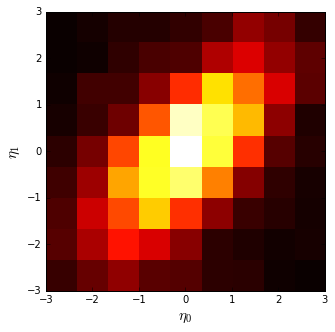

In [168]:
plt.show()

In [163]:
fig, _ = plot_2d_histogram(plot_data_ggH_2j, "JetEta[JetPt|0]", "JetEta[JetPt|1]", (-3,3,10), (-3,3,10), r'$\eta_{0}$', r'$\eta_{1}$', False)

[[ 1.          0.09640755]
 [ 0.09640755  1.        ]]


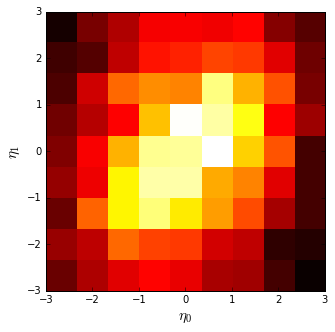

In [164]:
plt.show()

In [98]:
fig, _ = plot_2d_histogram(plot_data_ggH_1j, "D_VBF1j_ggH_ME", "D_bkg_ME", (0,1,20), (0,1,20), r'$\eta_{0}$', r'$\eta_{1}$', False)

[[ 1.         -0.00816768]
 [-0.00816768  1.        ]]


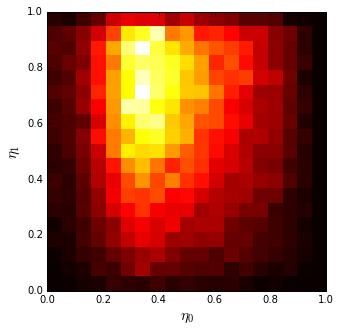

In [99]:
plt.show()

In [100]:
fig, _ = plot_2d_histogram(plot_data_VBF_1j, "D_VBF1j_ggH_ME", "D_bkg_ME", (0,1,20), (0,1,20), r'$\eta_{0}$', r'$\eta_{1}$', False)

[[ 1.          0.00225516]
 [ 0.00225516  1.        ]]


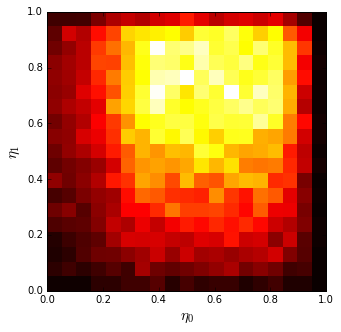

In [101]:
plt.show()

In [140]:
fig, _ = plot_2d_histogram(plot_data_ggH_2j, "D_VBF2j_ggH_ME", "D_ZHh_ggH_ME", (0,1,30), (0,1,30), r'$\eta_{0}$', r'$\eta_{1}$', True)

[[ 1.         -0.32697718]
 [-0.32697718  1.        ]]


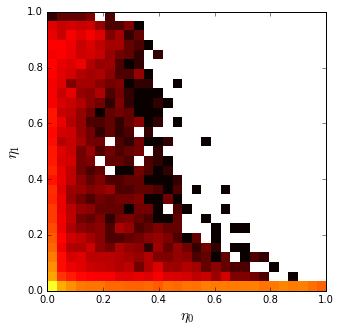

In [141]:
plt.show()

In [142]:
fig, _ = plot_2d_histogram(plot_data_VBF_2j, "D_VBF2j_ggH_ME", "D_ZHh_ggH_ME", (0,1,30), (0,1,30), r'$\eta_{0}$', r'$\eta_{1}$', True)

[[ 1.         -0.43790249]
 [-0.43790249  1.        ]]


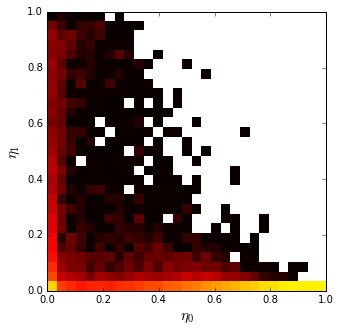

In [143]:
plt.show()

In [153]:
fig, _ = plot_2d_histogram(plot_data_ZHh_2j, "D_VBF2j_ggH_ME", "D_VBF2j_ZHh_ME", (0,1,20), (0,1,20), r'$\eta_{0}$', r'$\eta_{1}$', True)

[[ 1.          0.69204381]
 [ 0.69204381  1.        ]]


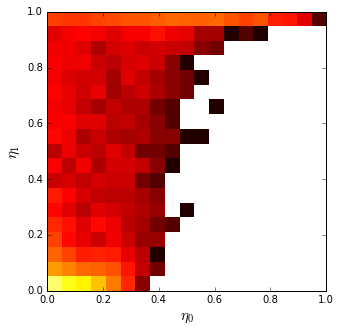

In [154]:
plt.show()

In [200]:
fig, _ = plot_2d_histogram(plot_data_VBF_0j, "D_bkg_ME", "ZZPt", (0,1,20), (0,100,20), r'$\eta_{0}$', r'$\eta_{1}$', True)

[[ 1.         -0.06243689]
 [-0.06243689  1.        ]]


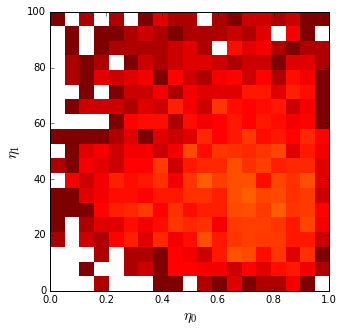

In [201]:
plt.show()

In [202]:
fig, _ = plot_2d_histogram(plot_data_ggH_0j, "D_bkg_ME", "ZZPt", (0,1,20), (0,100,20), r'$\eta_{0}$', r'$\eta_{1}$', True)

[[ 1.         -0.00616788]
 [-0.00616788  1.        ]]


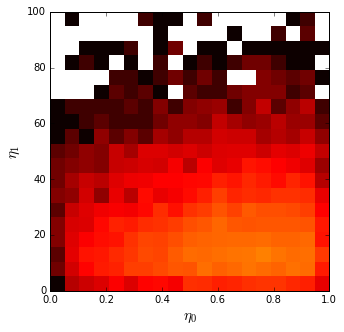

In [203]:
plt.show()

In [155]:
fig, _ = plot_2d_histogram(plot_data_VBF_2j, "D_VBF2j_ggH_ME", "D_VBF2j_ZHh_ME", (0,1,20), (0,1,20), r'$\eta_{0}$', r'$\eta_{1}$', True)

[[ 1.          0.73900865]
 [ 0.73900865  1.        ]]


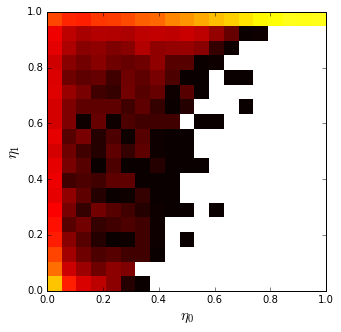

In [156]:
plt.show()

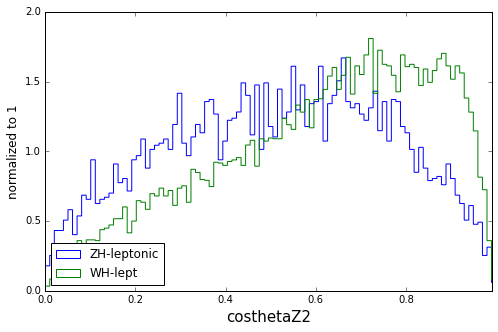

In [187]:
fig, H_ZX = plot_1d_histogram([plot_data_zhlept_mass_cut, plot_data_whlept_mass_cut], 
                              ["D_bkg_ME", "D_bkg_ME"], 
                              ["ZH-leptonic", "WH-lept"], (0., 1., 100), "costhetaZ2", "normalized to 1", log_scale = False)
plt.show()

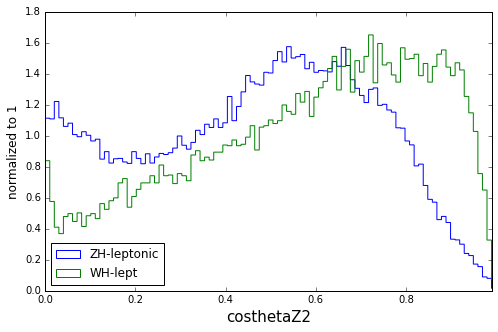

In [190]:
fig, H_ZX = plot_1d_histogram([plot_data_ZHl_inclusive, plot_data_WHl], 
                              ["D_bkg_ME", "D_bkg_ME"], 
                              ["ZH-leptonic", "WH-lept"], (0., 1., 100), "costhetaZ2", "normalized to 1", log_scale = False)
plt.show()

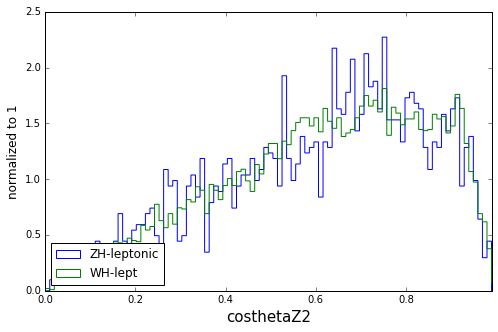

In [196]:
fig, H_ZX = plot_1d_histogram([plot_data_VBF_0j, plot_data_ggH_0j], 
                              ["D_bkg_ME", "D_bkg_ME"], 
                              ["ZH-leptonic", "WH-lept"], (0., 1., 100), "costhetaZ2", "normalized to 1", log_scale = False)
plt.show()

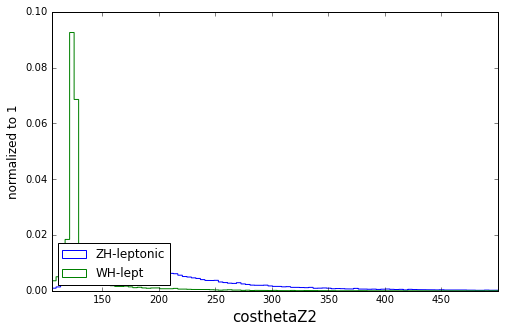

In [192]:
fig, H_ZX = plot_1d_histogram([plot_data_ZHl_inclusive, plot_data_WHl], 
                              ["ZZMass", "ZZMass"], 
                              ["ZH-leptonic", "WH-lept"], (105., 500., 100), "costhetaZ2", "normalized to 1", log_scale = False)
plt.show()

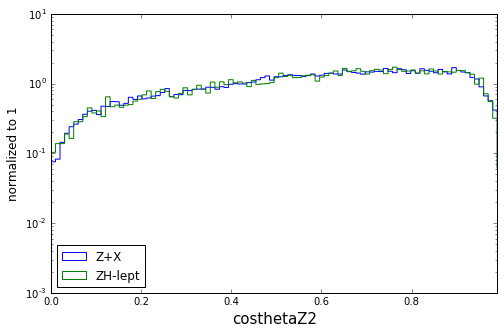

In [174]:
fig, H_ZX = plot_1d_histogram([plot_data_VBF_2j, plot_data_ggH_2j], 
                              ["D_bkg_ME", "D_bkg_ME"], 
                              ["Z+X", "ZH-lept"], (0., 1., 100), "costhetaZ2", "normalized to 1", log_scale = True)
plt.show()

In [184]:
x_edges = np.linspace(30, 500, 10)
y_edges = np.linspace(30, 500, 10)

In [196]:
fig = plt.figure()
ax = fig.add_subplot(111)

rel_change = np.abs(np.divide(H_VBF - H_ggH, np.maximum(H_VBF, H_ggH)))
rel_change = np.nan_to_num(rel_change)

abs_change = np.abs(H_VBF - H_ggH)

cax = ax.imshow(abs_change, interpolation = "nearest", cmap = "hot", origin = "low", 
                extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
fig.colorbar(cax)

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.


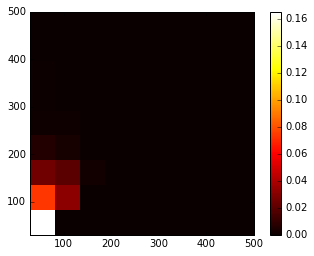

In [197]:
plt.show()

In [154]:
fig, _ = plot_2d_histogram(plot_data_ZHh, "ZZMass", "ZZMassErr", (0,800,100), (0,20,100), "ZZMass", "ZZMassErr", True)

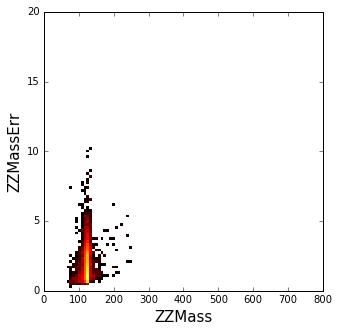

In [155]:
plt.show()

In [37]:
fig, _ = plot_2d_histogram(plot_data_ggH, "ZZMass", "ZZMassErr", (0,800,100), (0,20,100), "ZZMass", "ZZMassErr", True)

[[ 1.          0.04645654]
 [ 0.04645654  1.        ]]


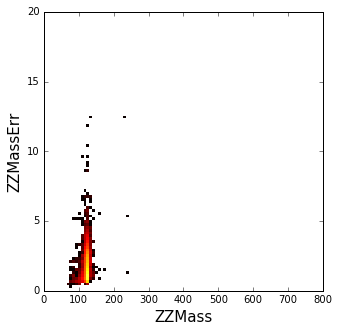

In [38]:
plt.show()

In [42]:
fig, _ = plot_2d_histogram(plot_data_ggH_allmasses, "ZZMass", "ZZMassErr", (0,800,100), (0,20,100), "ZZMass", "ZZMassErr", True)

[[ 1.          0.03243594]
 [ 0.03243594  1.        ]]


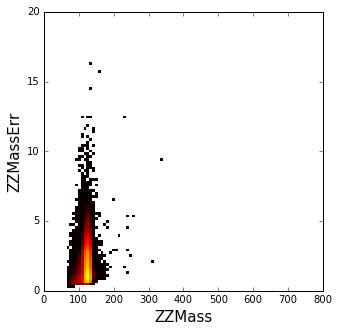

In [43]:
plt.show()

In [16]:
fig, _ = plot_2d_histogram(plot_data_ZHl_inclusive, "ZZMass", "ZZMassErr", (105,140,100), (0,20,100), "ZZMass", "ZZMassErr", True)

[[ 1.          0.72072816]
 [ 0.72072816  1.        ]]


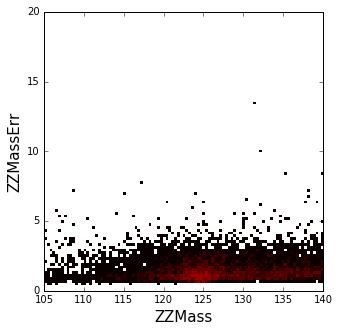

In [17]:
plt.show()

In [28]:
fig, _ = plot_2d_histogram(plot_data_gg4e, "ZZMass", "ZZMassErr", (0,800,100), (0,20,100), "ZZMass", "ZZMassErr", True)

[[ 1.          0.53923153]
 [ 0.53923153  1.        ]]


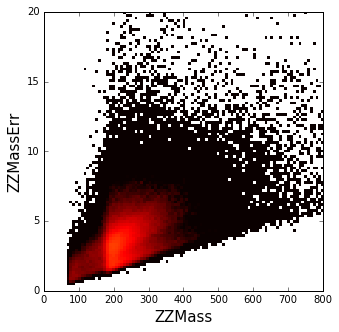

In [151]:
plt.show()

In [180]:
fig, _ = plot_2d_histogram_relative(plot_data_gg4e, "ZZMass", "ZZMassErr", (0,800,100), (0,0.2,100), r'$m(ZZ)$', r'$\sigma(m(ZZ))/m(ZZ)$', True)

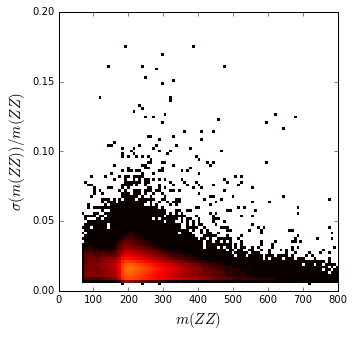

In [181]:
plt.savefig("/data_CMS/cms/wind/BackupPlots/mzz_rel_gg4e.pdf")
plt.show()

In [178]:
fig, _ = plot_2d_histogram_relative(plot_data_ZHh, "ZZMass", "ZZMassErr", (0,800,100), (0,0.2,100),  r'$m(ZZ)$', r'$\sigma(m(ZZ))/m(ZZ)$', True)

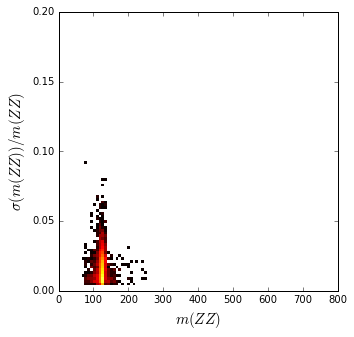

In [179]:
plt.savefig("/data_CMS/cms/wind/BackupPlots/mzz_rel_ZHh.pdf")
plt.show()

In [182]:
fig, _ = plot_2d_histogram_relative(plot_data_ZHl_inclusive, "ZZMass", "ZZMassErr", (0,800,100), (0,0.2,100),  r'$m(ZZ)$', r'$\sigma(m(ZZ))/m(ZZ)$', True)

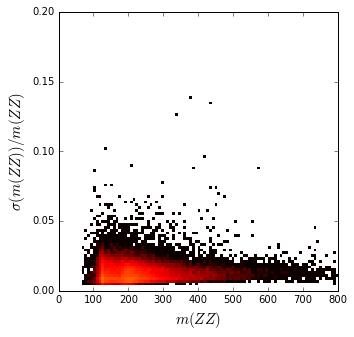

In [183]:
plt.savefig("/data_CMS/cms/wind/BackupPlots/mzz_rel_ZHl.pdf")
plt.show()

In [129]:
fig, _ = plot_2d_histogram(plot_data_ZHl_inclusive, "ZZMass", "LepPt[LepPt|0]", (0,250,100), (0,200,100), "ZZMass", "LepPt[LepPt|0]", True)

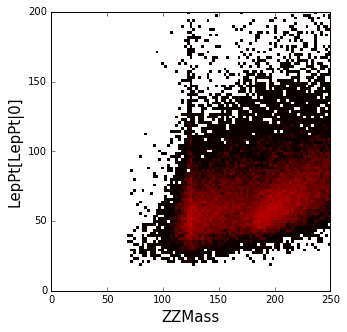

In [130]:
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


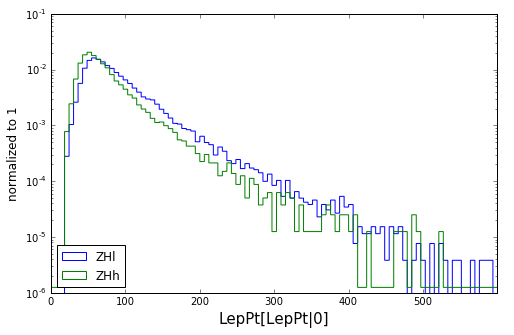

In [59]:
fig, H_ZX = plot_1d_histogram([plot_data_ZHl_inclusive, plot_data_ZHh], 
                              ["LepPt[LepPt|0]", "LepPt[LepPt|0]"], 
                              ["ZHl", "ZHh"], (0., 600, 100.), "LepPt[LepPt|0]", "normalized to 1", log_scale = True)
#plt.savefig("ZX_ZHl_Zhl_ZX.pdf")
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


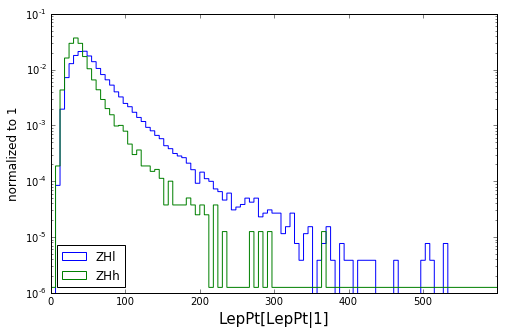

In [60]:
fig, H_ZX = plot_1d_histogram([plot_data_ZHl_inclusive, plot_data_ZHh], 
                              ["LepPt[LepPt|1]", "LepPt[LepPt|1]"], 
                              ["ZHl", "ZHh"], (0., 600, 100.), "LepPt[LepPt|1]", "normalized to 1", log_scale = True)
#plt.savefig("ZX_ZHl_Zhl_ZX.pdf")
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


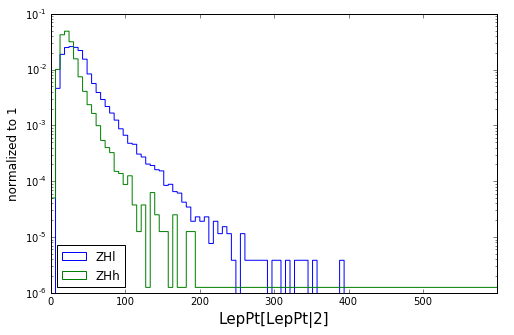

In [61]:
fig, H_ZX = plot_1d_histogram([plot_data_ZHl_inclusive, plot_data_ZHh], 
                              ["LepPt[LepPt|2]", "LepPt[LepPt|2]"], 
                              ["ZHl", "ZHh"], (0., 600, 100.), "LepPt[LepPt|2]", "normalized to 1", log_scale = True)
#plt.savefig("ZX_ZHl_Zhl_ZX.pdf")
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


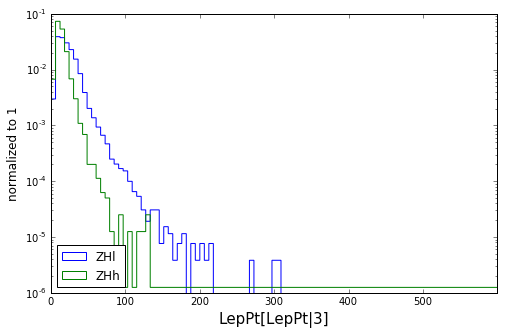

In [62]:
fig, H_ZX = plot_1d_histogram([plot_data_ZHl_inclusive, plot_data_ZHh], 
                              ["LepPt[LepPt|3]", "LepPt[LepPt|3]"], 
                              ["ZHl", "ZHh"], (0., 600, 100.), "LepPt[LepPt|3]", "normalized to 1", log_scale = True)
#plt.savefig("ZX_ZHl_Zhl_ZX.pdf")
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


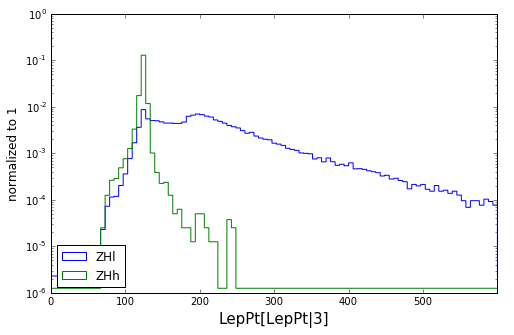

In [63]:
fig, H_ZX = plot_1d_histogram([plot_data_ZHl_inclusive, plot_data_ZHh], 
                              ["ZZMass", "ZZMass"], 
                              ["ZHl", "ZHh"], (0., 600, 100.), "LepPt[LepPt|3]", "normalized to 1", log_scale = True)
#plt.savefig("ZX_ZHl_Zhl_ZX.pdf")
plt.show()